### 主题建模与关注点分析

#### 文本预处理

1. 移除不合适单词
2. 分词
3. 停用词表

In [7]:
import pandas as pd
import re 
import jieba

# 匹配汉字(去掉数字符号emoji)
def match_chinese(text):
    chinese_pattern = r'[\u4e00-\u9fa5]+' # \u4e00-\u9fa5 用于表示Unicode中常见汉字的范围
    chinese_text = re.findall(chinese_pattern,text) # 在输入文本 text 中查找所有符合 chinese_pattern 模式的子串，并返回一个列表 chinese_text
    return chinese_text

# list -> string
def processWords(sentence):
    sentence_list = match_chinese(sentence)
    sentence = ''
    for sentence_l in sentence_list:
        sentence += sentence_l
    return sentence

# 分词
def segDepart(sentence):
    sentence_depart = jieba.lcut(str(sentence).strip())
    return sentence_depart
    
# 停用词表1
def getStopwordsList():
    stopwords = [line.strip() for line in open('cn_stopwords.txt',encoding = 'UTF-8').readlines()]
    return stopwords

# 停用词表2
def getStopwordsWeiboList():
    stopwords = [line.strip() for line in open('weibo_stopwords.txt',encoding = 'UTF-8').readlines()]
    return stopwords

# 去掉停用词
def moveStopwords(sentence_list,stopwords_list):
    out_list = [word for word in sentence_list if word not in stopwords_list]
    return out_list
    
# final
def ProcessData(filepath):

    data = pd.read_excel(filepath)

    text = []
    stop_list = getStopwordsList()

    for i in range(len(data)):
        str_row = data.iloc[i,3]
        
        # 移除不合适字符
        str_row = processWords(str_row)
        # 分词
        str_row = segDepart(str_row)
        # 停用词表
        line_without = moveStopwords(str_row,stop_list)
        
        # 移除特定的停用词
        stop_list_weibo = getStopwordsWeiboList()
        line_without = moveStopwords(line_without, stop_list_weibo)

        text.append(line_without)

    return text

In [3]:
processed_docs = ProcessData('weibo_data.xlsx')
processed_docs

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/jieba.cache
Loading model cost 0.968 seconds.
Prefix dict has been built successfully.


[['总台',
  '边上',
  '常去',
  '知玉渊二字',
  '玉渊',
  '之中',
  '驪',
  '龙蟠',
  '颔下',
  '有珠',
  '金代',
  '修起',
  '钓鱼台',
  '钓鱼台国宾馆',
  '名字',
  '便',
  '由此而来',
  '清代',
  '乾隆皇帝',
  '修行',
  '宫建',
  '园林',
  '进行',
  '开挖',
  '疏浚',
  '调洪',
  '蓄水',
  '水利'],
 ['樱花', '开'],
 ['游玩', '拍到', '金星', '伴月'],
 [],
 ['大寒', '腊梅', '开'],
 ['暮色', '云霞'],
 ['晚霞', '湖中', '升起', '照亮', '湖面', '点亮', '电视塔'],
 ['樱花', '开', '有着', '照见', '中央', '电视塔', '绝美', '景致', '春日', '氛围', '感'],
 ['日出'],
 ['鸭',
  '出没',
  '近年来',
  '越来越',
  '生态环境',
  '吸引',
  '大量',
  '野生',
  '鸟类',
  '越冬',
  '初冬',
  '时节',
  '公园',
  '东湖',
  '西湖',
  '成为',
  '鸟类',
  '乐园',
  '目前',
  '园内',
  '观测',
  '鸭子',
  '种类',
  '共',
  '十余种',
  '每天',
  '吸引',
  '大量',
  '打卡',
  '拍照',
  '园方',
  '提示',
  '文明',
  '观'],
 ['冬至',
  '风清',
  '视野',
  '阔',
  '霞光',
  '照水',
  '天鹅',
  '游戏',
  '见',
  '凫',
  '群',
  '日日',
  '觅食',
  '鸳鸯',
  '岸上',
  '相',
  '依偎',
  '夕阳',
  '无限',
  '近',
  '黄昏'],
 ['出过',
  '一期',
  '说',
  '德堡',
  '加上',
  '美帝',
  '历史',
  '投毒',
  '斑斑',
  '劣迹',
  '美帝',
  '制造',
  '新冠',
  '病毒'],
 ['固定',
  '

#### Latent Dirichlet Allocation (LDA) 主题模型
预处理文档到训练主题模型

In [4]:
import jieba
from gensim import corpora # 从 gensim 导入 corpora 模块，用于创建词典 (Dictionary) 和向量化语料库 (Corpus)。
from gensim.models import LdaModel
import string # 导入 string 库，尽管在这个片段中未使用，但通常用于文本清理（如移除标点符号）。

# 创建词典和语料库
# 创建词典。它遍历 processed_docs 中的所有词语，给每个唯一的词语分配一个唯一的整数 ID，并计算词频。
dictionary = corpora.Dictionary(processed_docs) 
# 创建语料库。调用 dictionary.doc2bow() 方法，将其转换为 词袋 (Bag-of-Words, BoW) 格式，即 [(词ID, 词频), ...] 的列表。
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# 训练 LDA 模型（假设提取 2 个主题）
lda_model = LdaModel(corpus,num_topics = 2,id2word = dictionary,passes = 15)
# corpus: 传入上一步创建的 BoW 格式语料库。	
# num_topics=2: 指定模型将提取 2 个主题。	
# id2word=dictionary: 传入词典，使模型能够将词 ID 映射回原始词语。	
# passes=15: 指定模型将完整遍历语料库 15 次进行训练（迭代次数，通常越多越精确，但耗时）。

# 输出主题
for idx,topic in lda_model.print_topics(num_words = 5):
    print(f'主题{idx + 1} : {topic}')
# 遍历模型的主题。lda_model.print_topics(num_words=5) 返回一个包含每个主题信息的元组列表：
# idx: 主题的索引（从 0 开始）。	
# topic: 包含主题中前 5 个最重要词语及其权重的字符串。

主题1 : 0.014*"樱花" + 0.005*"腊梅" + 0.005*"玩" + 0.005*"蜡梅" + 0.004*"室内"
主题2 : 0.004*"产品" + 0.003*"樱花" + 0.003*"国家" + 0.003*"庙会" + 0.003*"刷卡"


In [6]:
lda_model.print_topics(num_words = 9)

[(0,
  '0.014*"樱花" + 0.005*"腊梅" + 0.005*"玩" + 0.005*"蜡梅" + 0.004*"室内" + 0.004*"公园" + 0.003*"第二届" + 0.003*"线" + 0.003*"驿站"'),
 (1,
  '0.004*"产品" + 0.003*"樱花" + 0.003*"国家" + 0.003*"庙会" + 0.003*"刷卡" + 0.003*"引水渠" + 0.003*"聊" + 0.003*"做" + 0.003*"鸭"')]

#### 加载、预处理和准备文本数据

格式化：将最终的词语列表用空格连接成一个长字符串。

line_str = ' '.join(line_without)

核心差异行：使用空格 ' ' 将最终处理得到的词语列表 line_without 连接成一个单一的字符串。

In [8]:
def LoadData(filepath):

    # 读取文件
    data = pd.read_excel(filepath)

    text = []

    for i in range(len(data)):
        str_row = data.iloc[i,3]
        
        # 移除不合适单词
        str_row = processWords(str_row)
        # 分词
        str_row = segDepart(str_row)
        # 停用词
        stop_list = getStopwordsList()
        line_without = moveStopwords(str_row,stop_list)

        # 移除特定的停用词
        stop_list_weibo = getStopwordsWeiboList()
        line_without = moveStopwords(line_without, stop_list_weibo)

        line_str = ' '.join(line_without)
        text.append(line_str)

    return text

#### 文本数据聚类分析
利用经典的 TF-IDF + LSA + K-Means 组合模型，并包含结果的可视化和主题词提取

##### **TF-IDF (词频-逆文档频率) 向量化器中参数设置**

1. 为什么设置 **max_df = 0.5**？
max_df (Maximum Document Frequency) 表示最大文档频率。

- 含义: 一个词语如果在超过 50% (0.5) 的文档中出现，则它会被忽略，不会被包含在最终的词汇表中。

- 目的: 移除过于常见的词语，这些词语通常被称为通用停用词或高频噪音词。

- 原因:

    - 缺乏区分度: 如果一个词在大多数文档中都出现，那么它对区分不同文档或不同主题的作用很小。例如，中文中的“的”、“是”、“了”等（尽管这些已经通过停用词表移除，但仍可能有特定于语料库的高频词）。

    - 维度诅咒: 移除这些词可以有效降低特征维度，提高模型（如 K-Means）的训练速度和稳定性。

简而言之，max_df = 0.5 过滤掉那些在一半以上的文档中都出现，对聚类没有价值的“老好人”词语。

2. 为什么设置 **min_df = 2**？
min_df (Minimum Document Frequency) 表示最小文档频率。

- 含义: 一个词语如果在少于 2 个文档中出现，则它会被忽略，不会被包含在最终的词汇表中。

- 目的: 移除过于罕见的词语，这些词语通常是低频噪音词、拼写错误或数据错误。

- 原因:

    - 稀疏性问题: 仅仅在一个文档中出现的词语（即独词，min_df=1）会使 TF-IDF 矩阵极度稀疏。

    - 缺乏通用性: 极度罕见的词语往往是特定于单个文档的，它们几乎不可能帮助建立具有通用性的主题模型或聚类中心。将它们保留下来只会增加模型的计算负担，并引入噪音。

简而言之，min_df = 2 过滤掉那些只出现在单个文档中的词语，认为它们是噪音或不具有代表性。

##### **clusters = [[] for _ in range(n_clusters)]**

在 Python 代码 clusters = [[] for _ in range(n_clusters)] 中，下划线 _ 是一个惯用且有特定含义的变量名。

_ 的含义和用途
作为一次性变量（Ignored Variable）
在 Python 中，当你在循环或列表推导式中需要一个变量来迭代（即进行重复操作），但在循环体内部并不需要使用这个变量的值时，通常会使用 _ (单个下划线) 作为变量名。

在这种情况下，_ 的作用仅仅是占位符，表示“我需要在这里有一个变量来完成迭代，但我会忽略它的值”。

代码中的具体作用

range(n_clusters) 会生成一个数字序列（例如，如果 n_clusters=5，则序列是 0, 1, 2, 3, 4）。列表推导式会执行 $n\_clusters$ 次循环。在每一次循环中，都会创建一个新的空列表 []。循环变量本应是 i（像 for i in range(n_clusters)），但由于只需要重复创建 $n\_clusters$ 个空列表，而不需要知道当前是第 $i$ 次循环，所以就用 _ 来代替 i，表示忽略索引值。

假设 n_clusters = 3

clusters = [

    [],  # Cluster 0 的文档索引
    
    [],  # Cluster 1 的文档索引
    
    []   # Cluster 2 的文档索引
    
]

###### **original_space_centroids = svd.inverse_transform(km_X_tfidf_lsa.cluster_centers_)**

是文本聚类分析中一个**非常关键**的步骤，它用于解释聚类结果。

---

**代码行解释：聚类中心的反向映射**

`original_space_centroids = svd.inverse_transform(km_X_tfidf_lsa.cluster_centers_)`

1. 变量和函数分解

| 元素 | 含义 | 状态/作用 |
| :--- | :--- | :--- |
| `km_X_tfidf_lsa.cluster_centers_` | 这是 **K-Means 模型**训练后得到的**聚类中心**。 | 这些中心是**降维后**的向量（在您的代码中是 100 维）。它们位于 LSA/SVD 空间中。 |
| `svd` | 这是之前创建的 **`TruncatedSVD` 模型**（用于 LSA 降维）。 | 它保存了从高维（TF-IDF 空间）到低维（100 维 LSA 空间）的映射关系。 |
| `svd.inverse_transform(...)` | SVD 模型的方法，用于执行**反向映射**。 | 将输入向量从低维空间映射回原始的**高维空间**。 |
| `original_space_centroids` | 反向映射操作的**结果**。 | 这些中心现在是**原始维度**（即 TF-IDF 词汇表大小，成千上万维）的向量。 |

2. 为什么要进行反向映射？

在聚类流程中，数据经历了以下转换：

$$\text{原始文本} \xrightarrow{TF\text{-}IDF} X_{\text{tfidf}} (\text{高维}) \xrightarrow{SVD} X_{\text{tfidf}\_\text{lsa}} (\text{低维} 100\text{D})$$

K-Means 模型是在降维后的 $X_{\text{tfidf}\_\text{lsa}}$ 上运行的，所以它找到的聚类中心 $km.cluster\_centers\_$ 也是 100 维的。

**问题在于**：100 维的向量是原始特征（词语）的**抽象组合**，无法直接解释哪个词对聚类最重要。

**解决办法**：使用 `svd.inverse_transform()` 将低维聚类中心向量映射回原始的 **TF-IDF 空间**。

3. 反向映射的意义

映射回原始空间后，每个聚类中心 $original\_space\_centroids$ 仍然是一个向量，但它的**维度数量**与您的**词汇表大小**相同。

* 在这个高维向量中，每个位置对应一个**具体的词语**（由 `vectorizer_tfidf.get_feature_names_out()` 确定）。
* 向量中该位置上的**数值**，表示该词语对这个聚类中心的**重要性或权重**。

通过对这些权重进行排序，您就可以找出每个聚类中心**权重最高**的词语，从而为聚类**命名**或**解释其主题**，例如：

$$\text{Cluster} \ 1 \rightarrow \{\text{权重最高词} 1, \text{权重最高词} 2, \text{权重最高词} 3\}$$

这个步骤是实现 **LSA (潜在语义分析)** 结果可解释性的标准操作。 

##### **order_centroids = original_space_centroids.argsort()[:,::-1]**

文本聚类分析中，在获得了反向映射的聚类中心后，用于**确定每个主题（聚类）中最重要词语**的关键步骤。


1\. 变量和操作分解

| 元素 | 含义 | 作用 |
| :--- | :--- | :--- |
| `original_space_centroids` | 反向映射回**原始 TF-IDF 空间**的聚类中心矩阵。 | 矩阵形状为 ( $K$ 个聚类数, 词汇表大小)。矩阵中的值是词语对该聚类的**重要性权重**。 |
| `.argsort()` | **NumPy 数组方法**：返回对数组中元素进行排序后的**索引**。 | 对每个聚类中心向量（矩阵的每一行）内部的权重进行排序，返回对应词语的索引。 |
| `[:, ::-1]` | **NumPy 切片操作**：用于控制排序方向。 | \* `[:, ...]`：选择**所有行**（即所有聚类）。\* `[::-1]`：在第二个维度（列，即词语索引）上进行**反向切片**，实现**降序排列**。 |
| `order_centroids` | 最终结果矩阵。 | 矩阵形状与原矩阵相同。每一行包含一个聚类中心向量中**词语重要性由高到低**排列的词语索引。 |

2\. 详细步骤解释

这个操作可以分解为两个主要步骤：

步骤 A: 找到排序后的索引 (`.argsort()`)

假设一个聚类中心向量的权重如下：
$$\text{Centroid} = [0.1 (\text{词语 A}), 0.5 (\text{词语 B}), 0.2 (\text{词语 C})]$$

如果使用 `.argsort()`（默认是**升序**），它返回的索引是：
$$\text{Ascending Indices} = [0, 2, 1] \quad (\text{因为 } 0.1 < 0.2 < 0.5)$$

步骤 B: 反向排列 (`[:, ::-1]`)

由于我们希望找到权重**最高**的词语，我们需要**降序**排列。

在 NumPy 中，通常使用 `[::-1]` 切片操作来反转一个数组。当应用于 `.argsort()` 的结果时，它将索引数组反转，从而实现降序排序：

$$\text{Descending Indices} = [1, 2, 0] \quad (\text{因为 } 0.5 > 0.2 > 0.1)$$

这个结果矩阵 `order_centroids` 的每一行都是一个聚类，该行最左边的索引对应着该聚类**最重要的词语**，往右依次是次重要的词语。


In [25]:
# 1. 导入必要的库

from sklearn.feature_extraction.text import TfidfVectorizer # 导入 TfidfVectorizer，用于将文本数据转换为 TF-IDF (词频-逆文档频率) 向量。
from sklearn.preprocessing import Normalizer # 导入 Normalizer，用于归一化（L2范数归一化），确保向量具有单位长度。
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD # 导入 TruncatedSVD（截断奇异值分解），用于降维，尤其适用于稀疏矩阵（如 TF-IDF 矩阵）。
from sklearn.pipeline import make_pipeline 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # 导入 matplotlib.font_manager，用于指定中文字体，解决中文乱码问题。
from collections import Counter # 导入 Counter 类，用于高效地统计词语出现频率。
# %matplotlib inline # Jupyter 或 IPython 环境下的魔术命令，用于在代码单元格下方直接显示 Matplotlib 图表。
import seaborn as sns

# 2. 函数定义与参数 (getKmeans)

def getKmeans(filepath,name,n_clusters = 5,max_df = 0.5,min_df = 2,max_iter = 100,n_init = 1):
    """
    Perform KMeans clustering on text data and visualize the results in a pie chart.

    :param filepath: The path to the text data file
    :param name: A label for the clustering name (used in visualization and filename)
    :param n_clusters: The number of clusters for KMeans (default 5)
    :param max_df: 在文本中出现的“最大文档频率”。它指定了一个阈值，任何在超过 max_df 比例的文档中出现的词语都会被忽略。
    :param min_df: 在文本中出现的“最小文档频率”。它指定了一个阈值，只有在至少 min_df 文档中出现的词语才会被考虑。
    :param max_iter: 指定 KMeans 算法的最大迭代次数
    :param n_init: Number of initializations for KMeans
    """
    
    # 3. 数据加载与 TF-IDF 向量化

    # Load data (assuming a custom loadData function exists)
    data = LoadData(filepath)

    # 获得tf-idf向量
    vectorize_tfidf = TfidfVectorizer(max_df = max_df,min_df = min_df,use_idf = True)
    # 初始化 TF-IDF 向量化器，使用传入的 max_df 和 min_df 参数来过滤过于常见和过于罕见的词语。use_idf=True 确保启用 IDF 权重。
    X_tfidf = vectorize_tfidf.fit_transform(data)
    # 拟合 (学习词汇表和 IDF 权重) 并 转换 (将文本转换为稀疏矩阵形式的 TF-IDF 向量)。

    # 4. 降维与归一化 : 它通过 LSA (潜在语义分析) 提高聚类效果并加速计算
    
    # 使用SVD进行降维
    svd = TruncatedSVD(100) # 初始化 SVD 降维器，将特征维度从原始的词汇数量降至 100 维
    normalizer = Normalizer(copy = False) # 初始化归一化器，对降维后的向量进行归一化。copy=False 允许原地操作以节省内存。
    lsa = make_pipeline(svd,normalizer) # 创建一个 Pipeline，将 SVD 降维和 Normalizer 归一化步骤串联起来。
    X_tfidf_lsa = lsa.fit_transform(X_tfidf) # 将 TF-IDF 矩阵 X_tfidf 通过 LSA Pipeline 进行降维和归一化，得到最终用于聚类的矩阵。

    # 5. K-Means 聚类

    # 应用聚类
    # k-means++ ：初始化聚类中心的方法。是一种智能初始化方法，它通过选择一个远离已选择中心点的数据点作为新的中心来减少聚类收敛时的随机性。
    # max_iter 指定 KMeans 算法的最大迭代次数。即在没有收敛时，算法最多允许多少次更新聚类中心的位置。过小的 max_iter 可能导致算法没有完全收敛，过大的 max_iter 可能导致计算时间过长。
    # n_init: 指定算法运行的次数。每次运行都会随机初始化聚类中心，KMeans 会选择最佳的结果。多次运行有助于避免由于初始聚类中心选择不佳而导致的局部最优解。
    # verbose: 控制是否输出详细信息。设置为 True 时，算法运行过程中会输出每次迭代的信息；设置为 False 时，禁止输出信息。
    km = KMeans(n_clusters = n_clusters,
                init = 'k-means++',
                max_iter = max_iter,
                n_init = n_init,
                verbose = False)
    km_X_tfidf_lsa = km.fit(X_tfidf_lsa)

    # 6. 结果提取与主题词分析
    
    # 预测聚类 : 获取每个文档属于哪个聚类的标签。
    labels = km.predict(X_tfidf_lsa)

    # 统计聚类和每个对应的数目
    clusters = [[] for _ in range(n_clusters)] # 初始化一个列表，用于存储每个聚类下的文档索引。
    for idx,label in enumerate(labels):
        clusters[label].append(idx) # 遍历标签，将文档的原始索引 (idx) 添加到其对应的聚类列表 (label) 中。
    cluster_items = [len(cluster) for cluster in clusters] # 统计每个聚类中的文档数量。

    # 将聚类中心从降维后的空间映射回原始的TF-IDF特征空间
    original_space_centroids = svd.inverse_transform(km_X_tfidf_lsa.cluster_centers_) 
    # 将 K-Means 在 LSA 空间中找到的聚类中心（100维向量）反向映射回原始的 TF-IDF 特征空间（高维向量），以便进行主题解释。

    # 聚类中心中的每个元素按值排序。这里排序的是聚类中心向量中每个词的权重（重要性）
    order_centroids = original_space_centroids.argsort()[:,::-1]

    # 获取TF-IDF特征矩阵中每一列对应的词汇，即构建模型时所用的所有词汇
    terms = vectorize_tfidf.get_feature_names_out() # 获取 TF-IDF 向量化器学到的所有词语（即特征名称）。

    # 遍历每个聚类，提取其聚类中心向量中权重最高的前 3 个词语，用空格连接作为主题描述。
    tips = []
    for i in range(n_clusters):
        tip = ' '.join(terms[ind] for ind in order_centroids[i,:3]) # top3
        tips.append(tip)

    # 统计所有聚类中心的前3个关键词
    term_counts = Counter() # 初始化计数器。创建一个空的 Counter 对象，用于存储和统计词语的出现次数。

    for i in range(n_clusters):
        top_terms = [terms[ind] for ind in order_centroids[i,:3]]
        # 提取 Top 3 关键词。对于当前的第 $i$ 个聚类：* order_centroids[i, :3] 提取该聚类中心权重最高的前 3 个词语的索引。
        # terms[ind] 将这些索引映射回具体的词语字符串。* 结果 top_terms 是一个包含 3 个字符串的列表，例如 ['服务', '态度', '差']。
        term_counts.update(top_terms)
        # 更新计数。使用 Counter 的 .update() 方法，将 top_terms 列表中的词语添加到 term_counts 中，并自动增加每个词的计数
    print(term_counts)

    # 打印出现次数
    for term,count in term_counts.most_common():
        # .most_common() 方法会返回一个包含词语及其计数的列表，列表中的元素是 (term, count) 元组，并且默认按 count 降序排列。
        print(f"{term}: {count}")

    print("Cluster sizes:", cluster_items)
    print("Top terms per cluster:")
    for i, tip in enumerate(tips):
        print(f"Cluster {i}: {tip}")

    # 7. 饼图可视化
    
    # 指定 SimHei 字体路径
    font_path = 'SIMHEI.TTF'
    
    # 应用到 Matplotlib
    my_font = fm.FontProperties(fname=font_path)
    plt.rcParams['axes.unicode_minus'] = False  # 避免负号显示错误
    
    # 绘制饼状图
    plt.figure(figsize=(8, 6))  # 设置图表大小
    sns.set(palette = 'crest')
    plt.pie(
        cluster_items,
        labels=tips,  # 设置饼图标签
        autopct="(%1.1f%%)",  # 饼块内标签
        textprops={"fontproperties": my_font},  # 设置字体
    )

    plt.title(f"{name} 聚类饼状图", fontproperties=my_font)  # 指定字体

    # **先保存再显示**
    save_path = f"{name} 聚类分析饼状图.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 高分辨率保存
    plt.show()  # 显示图像

Counter({'体验': 1, '节日': 1, '小屋': 1, '腊梅': 1, '鸳鸯': 1, '傍晚': 1, '养蜂人': 1, '散步': 1, '棚子': 1, '蜡梅': 1, '向东': 1, '吸引': 1, '樱花': 1, '室内': 1, '表演': 1})
体验: 1
节日: 1
小屋: 1
腊梅: 1
鸳鸯: 1
傍晚: 1
养蜂人: 1
散步: 1
棚子: 1
蜡梅: 1
向东: 1
吸引: 1
樱花: 1
室内: 1
表演: 1
Cluster sizes: [1, 87, 2, 5, 11]
Top terms per cluster:
Cluster 0: 体验 节日 小屋
Cluster 1: 腊梅 鸳鸯 傍晚
Cluster 2: 养蜂人 散步 棚子
Cluster 3: 蜡梅 向东 吸引
Cluster 4: 樱花 室内 表演


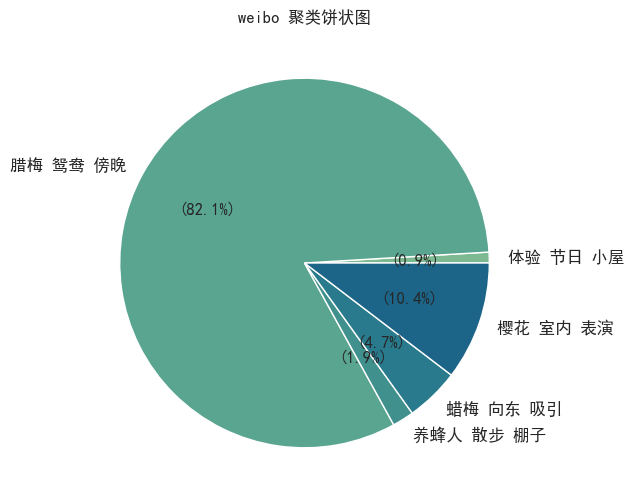

In [26]:
getKmeans('weibo_data.xlsx','weibo')

### 相似度

#### 使用 BERT (Bidirectional Encoder Representations from Transformers) 模型计算句子间语义相似度
计算余弦相似度

**embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()**

这行代码是利用 BERT 模型获取**句子级别嵌入（Sentence Embedding）**的**核心步骤**。

1. `outputs.last_hidden_state`：获取模型的最终输出

当您将编码后的输入（tokens）传入 `BertModel` 后，`outputs` 对象包含了模型每一层的输出。

* `outputs.last_hidden_state` 是 BERT 模型的**最后一层**（通常是第 12 层或第 24 层）的**隐藏状态**。

这个张量的**形状（Shape）**通常是 `(Batch Size, Sequence Length, Hidden Size)`：

* **`Batch Size`**: 您一次性传入的句子数量（这里是 1）。
* **`Sequence Length`**: 经过分词、填充和添加特殊 token（如 `[CLS]`, `[SEP]`）后，句子的总长度。
* **`Hidden Size`**: BERT 模型输出的向量维度（对于 `bert-base` 模型，通常是 $768$）。

**总结：** 这是一个三维张量，包含了序列中**每个 token** 的 $768$ 维上下文相关向量。

---

2. `[:, 0, :]`：提取 [CLS] Token 的向量

这是提取句子嵌入的关键切片操作。

* **BERT 惯例：** 在 BERT 的设计中，当句子被分词并输入模型时，第一个 token 总是特殊的分类 token **`[CLS]`**。BERT 被训练成将整个句子的**全局语义信息**聚合到这个 `[CLS]` token 的隐藏状态中。
* **切片操作：**
    * `:`: 选取 **所有 Batch Size**（即所有输入的句子）。
    * `0`: 选取序列的**第一个位置**（索引为 $0$），也就是 **`[CLS]` token** 的位置。
    * `:`: 选取该 token 向量的 **所有 Hidden Size** 维度（即整个 $768$ 维向量）。

**总结：** 这个操作的结果是一个形状为 `(Batch Size, 1, Hidden Size)` 的二维张量（或者在 NumPy 中常被挤压成 `(Batch Size, Hidden Size)`），它代表了每个输入句子的**语义嵌入向量**。

---

3. `.detach().numpy()`：格式转换

剩下的部分是将 PyTorch 的计算结果转换为标准的 NumPy 数组格式，方便后续计算（例如 `cosine_similarity`）。

* **`.detach()`**: 将张量从当前的 **PyTorch 计算图**中分离出来。这是因为我们只想要提取最终的数值，而不需要对这个值进行反向传播或梯度计算。
* **`.numpy()`**: 将分离后的 Py量张量转换为标准的 **NumPy `ndarray`** 数组。

**总结：** 使得提取出的句子嵌入向量能够被 `sklearn` 或其他依赖 NumPy 的库直接使用。

---

最终意义

整行代码的作用是：

> **从 BERT 模型的最后一层输出中，提取第一个 token（即 `[CLS]` token）的隐藏状态向量，并将其转换为一个可用于后续科学计算的 NumPy 数组。这个向量被视为该输入句子的 $768$ 维语义嵌入。**

**print(f"BERT相似度: {similarity_bert[0][0]}")**

打印最终的相似度得分。由于 cosine_similarity 返回一个 $1 \times 1$ 的矩阵（如果只传入了一对向量），因此需要通过 [0][0] 来提取相似度值。

In [28]:
from transformers import BertTokenizer,BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity # 导入 sklearn 中的 cosine_similarity 函数，用于计算向量间的相似度。

# 加载预训练BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # 加载预训练的 BERT 分词器。bert-base-uncased 是一个基础、不区分大小写的英文 BERT 模型。
model = BertModel.from_pretrained('bert-base-uncased') # 加载预训练的 BERT 模型本身。

# 计算句子嵌入
def get_sentence_embedding(sentence):
    # 分词 + 编码
    inputs = tokenizer(sentence,
                       return_tensors = 'pt',
                       truncation = True, # 如果任何句子超过了模型的最大长度限制（通常是 512），则对其进行截断
                       padding = True, # 对较短的句子进行填充（Padding），使其与批次中最长的句子长度一致，方便批量处理
                       max_length = 512)
    outputs = model(**inputs) # 将编码后的输入传入 BERT 模型，获得模型的输出（包括所有层的隐藏状态）。
    # 获取[CLS] token的输出作为句子向量
    # 我们使用 BERT 来获取句子级别的向量表示。
    # 具体来说，BERT 会为每个单词生成一个上下文相关的向量表示，
    # 而我们通常使用句子的 [CLS] token（即句子的第一个 token）来代表整个句子的语义。
    embedding = outputs.last_hidden_state[:,0,:].detach().numpy()
    return embedding

# 计算两个句子的嵌入
sentence_1 = 'the king is wearing a crown'
sentence_2 = 'the queen is wearing a crown'

embedding_1 = get_sentence_embedding(sentence_1)
embedding_2 = get_sentence_embedding(sentence_2)

# 计算余弦相似度
similarity_bert = cosine_similarity(embedding_1,embedding_2)
print(f"BERT相似度: {similarity_bert[0][0]}")

'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: 40486a44-ae5c-4609-859f-201c8df62ae3)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt
Retrying in 1s [Retry 1/5].
'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: 54aaa901-a63b-4fca-91f4-4d60af6d2d5f)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt
Retrying in 2s [Retry 2/5].
'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: d4dd7639-1770-4184-a03f-314e1f924657)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt
Retrying in 4s [Retry 3/5].
'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: 5d6323fe-5dc6-420d-ba79-a7926ec47a8a)')' thrown while requesting HEAD https://hugg

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT相似度: 0.9854034781455994


#### 数据预处理函数

这个新函数的目的是根据数据的第一列（索引为 0）的关键词进行筛选，然后将所有符合条件的文本内容进行预处理并合并成一个巨大的单一字符串。

In [29]:
def ProcessDataByKeyword(filepath,keyword):
    data = pd.read_excel(filepath)
    
    text = ''
    stop_list = getStopwordsList()
    for i in range(len(data)):
        if (data.iloc[i,0] == keyword):
            str_row = data.iloc[i,3]
            # 移除不合适的字符
            str_row = processWords(str_row)
            # 分词
            str_row = segDepart(str_row)
            # 移除停用词
            line_without = moveStopwords(str_row, stop_list)
            
            # 移除特定的停用词
            stop_listWeibo = getStopwordsWeiboList()
            line_without = moveStopwords(line_without, stop_listWeibo)

            lineStr = ' '.join(line_without)
            text += lineStr

        return text

In [38]:
sentence_1 = ProcessDataByKeyword('weibo_data1.xlsx','玉渊潭')
sentence_2 = ProcessDataByKeyword('weibo_data1.xlsx','天坛')

#### 针对中文文本进行 BERT 语义相似度计算

In [39]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# 加载中文BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')

# 计算句子嵌入
def get_sentence_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    # 获取[CLS] token的输出作为句子向量
    embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return embedding

# 计算两个句子的嵌入

embedding_1 = get_sentence_embedding(sentence_1)
embedding_2 = get_sentence_embedding(sentence_2)

# 计算余弦相似度
similarity_bert = cosine_similarity(embedding_1, embedding_2)

print(f"BERT 相似度: {similarity_bert[0][0]}")


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly 

BERT 相似度: 0.20044025778770447
